# Skin lesion classification of dermoscopic images using machine learning and convolutional neural network

19 December 2022

https://www.nature.com/articles/s41598-022-22644-9#Tab7

https://aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=561

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import glob
import json
import re
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
def get_image_and_json_paths(src_path, num_files):
    image_paths = []
    json_paths = []

    for root, dirs, files in tqdm(os.walk(src_path), desc='Walking directories', unit=' dir'):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            image_paths.extend(sorted(glob.glob(os.path.join(dir_path, '*.jpg'))[:num_files]))
            json_paths.extend(sorted(glob.glob(os.path.join(dir_path, '*.json'))[:num_files]))

    return image_paths, json_paths

def extract_data_from_json(json_paths):
    lesions, polygon_locations, box_locations = [], [], []
    for json_path in tqdm(json_paths, desc='Loading JSON', unit=' file'):
        try:
            with open(json_path, 'r', encoding='utf-8') as file:
                json_data = json.loads(re.sub(r'[\x00-\x1F\x7F-\x9F]', '', file.read()))
                metadata, labeling_info = json_data.get('metaData', None), json_data['labelingInfo']

                lesions.append(metadata.get('lesions', None))

                for entry in labeling_info:
                    if 'polygon' in entry:
                        polygon_locations.extend(entry['polygon'].get('location', None))
                    if 'box' in entry:
                        box_locations.extend(entry['box'].get('location', None))

        except Exception as e:
            print(json_path)
            print(e)

    return lesions, polygon_locations, box_locations

def preprocess_image(image, target_size):
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def create_dataset(image_paths, labels, buffer_size, batch_size, target_size):
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(lambda x: tf.io.read_file(x))
    image_dataset = image_dataset.map(lambda x: tf.image.decode_jpeg(x, channels=3))
    image_dataset = image_dataset.map(lambda x: preprocess_image(x, target_size))

    labels_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))

    dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size)

    return dataset

def find_corrupted_images(image_paths):
    for image_path in tqdm(image_paths, desc='Checking Image'):
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
        except (tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as e:
            print("Corrupted Image Path:", image_path)

# camera cat

In [7]:
src_path = '/content/drive/Shareddrives/반려묘/일반카메라'
num_files = 1350
buffer_size = 1000
batch_size = 64
target_size = (96, 96)

image_paths, json_paths = get_image_and_json_paths(src_path, num_files)
lesions, polygon_locations, box_locations = extract_data_from_json(json_paths)

onehot_encoder = OneHotEncoder(sparse_output=False)
lesions_array = np.array(lesions)
onehot_encoded = onehot_encoder.fit_transform(lesions_array.reshape(-1, 1))

Walking directories: 14 dir [01:19,  5.70s/ dir]
Loading JSON: 100%|██████████| 14175/14175 [1:18:17<00:00,  3.02 file/s]


In [8]:
corrupted_image_paths = find_corrupted_images(image_paths)

Checking Image: 100%|██████████| 14175/14175 [1:23:07<00:00,  2.84it/s]


In [9]:
image_paths_shuffled, onehot_encoded_shuffled = shuffle(image_paths, onehot_encoded, random_state=42)

train_image_paths, remaining_image_paths, train_labels, remaining_labels = train_test_split(
    image_paths_shuffled, onehot_encoded_shuffled, train_size=0.8, random_state=42)

val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    remaining_image_paths, remaining_labels, test_size=0.5, random_state=42)

train_dataset = create_dataset(train_image_paths, train_labels, buffer_size, batch_size, target_size)
val_dataset = create_dataset(val_image_paths, val_labels, buffer_size, batch_size, target_size)
test_dataset = create_dataset(test_image_paths, test_labels, buffer_size, batch_size, target_size)

train_size = len(train_image_paths)
val_size = len(val_image_paths)
test_size = len(test_image_paths)

print("Train dataset size:", train_size)
print("Validation dataset size:", val_size)
print("Test dataset size:", test_size)

Train dataset size: 11340
Validation dataset size: 1417
Test dataset size: 1418


Label: [0. 1. 0. 0.]
Label: [0. 1. 0. 0.]
Label: [1. 0. 0. 0.]
Label: [0. 0. 1. 0.]


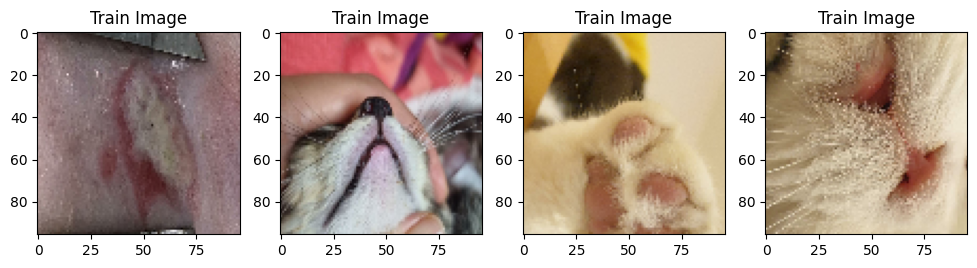

Label: [0. 0. 0. 1.]
Label: [1. 0. 0. 0.]
Label: [0. 0. 1. 0.]
Label: [0. 0. 0. 1.]


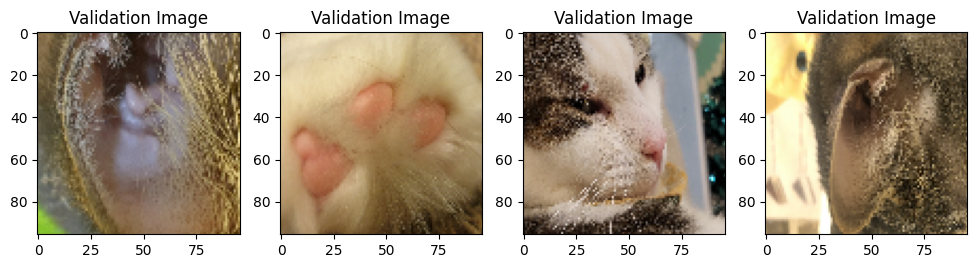

Label: [0. 0. 0. 1.]
Label: [0. 0. 0. 1.]
Label: [0. 0. 0. 1.]
Label: [0. 1. 0. 0.]


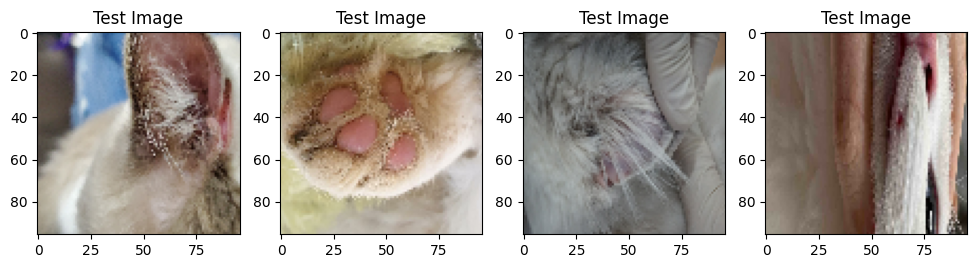

In [10]:
for batch in train_dataset.take(1):
    images, labels = batch
    plt.figure(figsize=(12, 12))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Train Image")
        print("Label:", labels[i].numpy())
    plt.show()

for batch in val_dataset.take(1):
    images, labels = batch
    plt.figure(figsize=(12, 12))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Validation Image")
        print("Label:", labels[i].numpy())
    plt.show()

for batch in test_dataset.take(1):
    images, labels = batch
    plt.figure(figsize=(12, 12))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Test Image")
        print("Label:", labels[i].numpy())
    plt.show()


In [11]:
labels = [label.numpy() for _, label in train_dataset]

labels = np.concatenate(labels, axis=0)

unique_labels, label_counts = np.unique(labels, return_counts=True, axis=0)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}, Ratio: {count / len(labels)}")

Label: [0. 0. 0. 1.], Count: 6483, Ratio: 0.5716931216931217
Label: [0. 0. 1. 0.], Count: 1615, Ratio: 0.1424162257495591
Label: [0. 1. 0. 0.], Count: 2161, Ratio: 0.19056437389770722
Label: [1. 0. 0. 0.], Count: 1081, Ratio: 0.09532627865961199


In [12]:
labels = [label.numpy() for _, label in val_dataset]

labels = np.concatenate(labels, axis=0)

unique_labels, label_counts = np.unique(labels, return_counts=True, axis=0)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}, Ratio: {count / len(labels)}")

Label: [0. 0. 0. 1.], Count: 806, Ratio: 0.5688073394495413
Label: [0. 0. 1. 0.], Count: 228, Ratio: 0.16090331686661963
Label: [0. 1. 0. 0.], Count: 267, Ratio: 0.18842625264643614
Label: [1. 0. 0. 0.], Count: 116, Ratio: 0.08186309103740297


In [13]:
labels = [label.numpy() for _, label in test_dataset]

labels = np.concatenate(labels, axis=0)

unique_labels, label_counts = np.unique(labels, return_counts=True, axis=0)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}, Ratio: {count / len(labels)}")

Label: [0. 0. 0. 1.], Count: 811, Ratio: 0.5719322990126939
Label: [0. 0. 1. 0.], Count: 182, Ratio: 0.12834978843441466
Label: [0. 1. 0. 0.], Count: 272, Ratio: 0.1918194640338505
Label: [1. 0. 0. 0.], Count: 153, Ratio: 0.1078984485190409


In [14]:
model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(96,96,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=4, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [15]:
history = model.fit(
    train_dataset,
    epochs=150,
    batch_size=64,
    validation_data=val_dataset,
)

Epoch 1/150
178/178 [==============================] - 148s 800ms/step - loss: 1.4076 - accuracy: 0.5384 - val_loss: 1.4680 - val_accuracy: 0.5702
Epoch 2/150
178/178 [==============================] - 141s 775ms/step - loss: 1.0241 - accuracy: 0.6254 - val_loss: 1.4680 - val_accuracy: 0.3881
Epoch 3/150
178/178 [==============================] - 140s 773ms/step - loss: 0.9679 - accuracy: 0.6431 - val_loss: 1.4117 - val_accuracy: 0.5759
Epoch 4/150
178/178 [==============================] - 139s 767ms/step - loss: 0.8818 - accuracy: 0.6740 - val_loss: 1.1160 - val_accuracy: 0.5935
Epoch 5/150
178/178 [==============================] - 140s 772ms/step - loss: 0.8539 - accuracy: 0.6798 - val_loss: 1.0138 - val_accuracy: 0.6154
Epoch 6/150
178/178 [==============================] - 150s 829ms/step - loss: 0.8193 - accuracy: 0.6909 - val_loss: 1.2586 - val_accuracy: 0.5646
Epoch 7/150
178/178 [==============================] - 142s 782ms/step - loss: 0.7847 - accuracy: 0.7102 - val_loss: 0

KeyboardInterrupt: ignored

In [ ]:
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(onehot_encoded[train_size + val_size:], axis=1)
print(classification_report(y_true_classes, y_pred_classes))

In [ ]:
# TensorFlow Lite 모델로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 변환된 모델을 파일로 저장
with open('Mk-1.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
import cv2
import numpy as np
from skimage.feature import greycomatrix
import h5py

class ImageFeatureExtractor:
    def __init__(self, target_size=(96, 96)):
        self.target_size = target_size

    def preprocess_image(self, image_path):
        image = cv2.imread(image_path)
        image = cv2.resize(image, self.target_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def extract_color_histogram(self, image):
        histogram = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        histogram = cv2.normalize(histogram, histogram).flatten()
        return histogram

    def extract_hu_moments(self, image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        moments = cv2.HuMoments(cv2.moments(gray_image)).flatten()
        return moments

    def extract_haralick_texture(self, image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        texture = greycomatrix(gray_image, distances=[1], angles=[0], symmetric=True, normed=True)
        haralick_features = np.mean(texture, axis=(0, 1, 2))
        return haralick_features

    def extract_features(self, image_path):
        image = self.preprocess_image(image_path)
        color_histogram = self.extract_color_histogram(image)
        hu_moments = self.extract_hu_moments(image)
        haralick_texture = self.extract_haralick_texture(image)
        global_features = np.concatenate([color_histogram, hu_moments, haralick_texture])
        return global_features

    def save_features_to_hdf5(self, features, lesions, output_path):
        with h5py.File(output_path, 'w') as f:
            f.create_dataset('features', data=features)
            f.create_dataset('lesions', data=lesions)

def load_data_from_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        features = f['features'][:]
        lesions = f['lesions'][:]
    return features, lesions

In [ ]:
feature_extractor = ImageFeatureExtractor(target_size=(96, 96))

features = []
for image_path in image_paths:
    image_features = feature_extractor.extract_features(image_path)
    features.append(image_features)

features = np.array(features)
lesions = np.array(lesions)

output_path = 'features.h5'
feature_extractor.save_features_to_hdf5(features, lesions, output_path)

In [ ]:
hdf5_file_path = 'path_to_your_hdf5_file.hdf5'

features, lesions = load_data_from_hdf5(hdf5_file_path)

X_train, X_test, y_train, y_test = train_test_split(features, lesions, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
history2 = model.fit(X_train, X_test, epochs=150, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

In [ ]:
def combine_images_and_masks(image_list, mask_list):
    combined_images = []

    for i in tqdm(range(len(image_list)), desc='Combining Images and Masks'):
        image = image_list[i]
        mask = mask_list[i]

        mask_channel = np.zeros_like(image[:, :, 0], dtype=np.uint8)

        mask_channel[mask == 1] = 255

        combined_image = np.dstack((image, mask_channel))

        combined_images.append(combined_image)

    return combined_images

def one_hot_encode_labels(labels):
    label_binarizer = LabelBinarizer()
    encoded_labels = label_binarizer.fit_transform(labels)
    return np.array(encoded_labels), label_binarizer

def create_polygon_binary_masks(image_list, polygon_locations_list):
    binary_masks = []

    for image, polygon_locations in tqdm(zip(image_list, polygon_locations_list), desc='Generating Binary Masks', total=len(image_list)):
        mask = np.zeros(image.shape[:2], dtype=np.uint8)

        for poly_coords in polygon_locations:
            if poly_coords:
                poly_points = []
                i = 1
                while f'x{i}' in poly_coords and f'y{i}' in poly_coords:
                    x = poly_coords[f'x{i}']
                    y = poly_coords[f'y{i}']
                    poly_points.append([x, y])
                    i += 1
                if len(poly_points) > 0:
                    poly_points = np.array(poly_points, dtype=np.int32)
                    cv2.fillPoly(mask, [poly_points], 255)
            print(poly_coords)

        binary_masks.append(mask)

    return binary_masks

def visualize_masks(image_data, mask_data, selected_indices, figsize=(10, 5)):
    for idx in selected_indices:
        image = image_data[idx]
        mask_map = mask_data[idx]

        plt.figure(figsize=figsize)
        plt.subplot(1, mask_map.shape[2] + 1, 1)
        plt.imshow(image)
        plt.title('Original Image')

        for ch in range(mask_map.shape[2]):
            plt.subplot(1, mask_map.shape[2] + 1, ch + 2)
            plt.imshow(mask_map[:, :, ch], cmap='gray')
            plt.title(f'Channel {ch}')

        plt.tight_layout()
        plt.show()

# microscope cat

In [ ]:
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Concatenate, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mean_squared_error

def inception_module(input_layer, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), activation='relu')(input_layer)
    conv3x3_reduce = Conv2D(filters[1], (1, 1), activation='relu')(input_layer)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3_reduce)
    conv5x5_reduce = Conv2D(filters[3], (1, 1), activation='relu')(input_layer)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5_reduce)
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_layer)
    maxpool_conv = Conv2D(filters[5], (1, 1), activation='relu')(maxpool)
    inception_output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool_conv])
    return inception_output

# Input
input_shape = (128, 128, 3)
input_layer = Input(shape=input_shape)

# Inception block
inception_output = inception_module(input_layer, filters=[64, 128, 192, 32, 96, 64])
inception_output = inception_module(inception_output, filters=[64, 128, 192, 32, 96, 64])
# Add more inception modules if needed

# Primary Capsule layer
primary_capsules = Conv2D(32, (1, 1), activation='relu')(inception_output)

# Higher Capsule layers
# (Add imperative routing mechanism layers here)

# PReLU activation for routing
higher_capsules_prelu = PReLU()(higher_capsules)

# Flatten and Fully Connected layers
capsule_flatten = Flatten()(higher_capsules_prelu)  # Flatten higher capsules
output_layer = Dense(2, activation='softmax')(capsule_flatten)  # Two capsules: parasitized and uninfected

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with Adam optimizer and custom loss function
optimizer = Adam(learning_rate=0.007, beta_1=0.8)
loss_fn = custom_loss_function # Define the custom loss function as described in the paper
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Print the model summary
model.summary()